In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
try:
    df = pd.read_csv("cleaned_project_data.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found. Please ensure the file is in the correct directory.")
    # Exiting the script if the file is not found
    exit()

Dataset loaded successfully.


In [33]:
training_columns = [
    'PatientAge', 'PatientHasPosGp', 'PartenerHasPosGp', 'bmi', 'conception',
    'First degree relative with following medical conditions', 'PreviouslyDiagnosedMedicalConditions',
    'Number of Previous Childbirths after 28 Weeks', 'Outcome of Previous Pregnancies (Select all that apply):',
    'Mode of Delivery in Previous Pregnancies', 'History of Ruptured Uterus',
    'Number of Abortions (Births before 28 Weeks)', 'Interval from Last Pregnancy (in years)',
    'Previous history of Intrauterine Growth Restriction (IUGR)',
    'Any other Antenatal, Postnatal, or Delivery Complications both fetal and maternal',
    'If responded "Yes" in previous question, then please specify',
    'Gestational Age (GA) (in weeks)', 'Labor Pains currently',
    'Watery Vaginal Discharge currently', 'Bleeding/Spotting currently',
    'Reduced Fetal Movement (FM) currently', 'Mental Health Symptoms',
    'Other Symptoms (Select all that apply)',
    'Medicines in Use currently',
    'Previous Medicines Record (used for long term or frequently taken):',
    'Number of Cesarean Sections (C-sections)',
    'Number of ERPC (Evacuation of Retained Products of Conception)',
    'Previous history of PPH (Postpartum Hemorrhage) Exploration',
    'Any Anesthesia Complication previously',
    'Pallor', 'Jaundice', 'Thyroid enlarged', 'Edema', 'Coarse facial hair',
    'Systolic B.P', 'Diastolic BP', 'Pulse in full 1 minute',
    'Respiratory rate in full 1 minute', 'Temp. ( armpit for 2 ) in *F',
    'Per abdominal examination : Fundal height in weeks',
    'Per abdominal examination: Lie', 'Per abdominal examination: Presentation',
    'Per speculum examination',
    'Per speculum examination (If Yes, specify findings)',
    'Per vaginal examination',
    'Per vaginal examination (If Yes, specify findings)',
    'Neonatal Apgar Score:(1 Minute)', 'Neonatal Apgar Score:(5 Minute)',
    'Mode_of_delivery2', 'Antenatal_Peripartum_Maternal_Complications',
    'History of any abdominal or pelvic surgery', 'Any Uterine Surgery previously (Other than Cesarean Section)'
]

target_column = 'Neonatal__Fetal_Complications'

In [34]:
required_columns = training_columns + [target_column]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing from the dataset: {missing_columns}")
    # Exiting the script if required columns are not found
    exit()

In [35]:
print("\n--- Initial Data Exploration ---")
print(f"Total number of rows: {df.shape[0]}")
print("\nUnique values per column:")
for col in training_columns:
    print(f"  {col}: {df[col].nunique()} unique values")
# Print unique values for the single target column
print(f"  {target_column}: {df[target_column].nunique()} unique values")


--- Initial Data Exploration ---
Total number of rows: 10560

Unique values per column:
  PatientAge: 34 unique values
  PatientHasPosGp: 13 unique values
  PartenerHasPosGp: 16 unique values
  bmi: 239 unique values
  conception: 4 unique values
  First degree relative with following medical conditions: 56 unique values
  PreviouslyDiagnosedMedicalConditions: 48 unique values
  Number of Previous Childbirths after 28 Weeks: 11 unique values
  Outcome of Previous Pregnancies (Select all that apply):: 40 unique values
  Mode of Delivery in Previous Pregnancies: 24 unique values
  History of Ruptured Uterus: 2 unique values
  Number of Abortions (Births before 28 Weeks): 7 unique values
  Interval from Last Pregnancy (in years): 12 unique values
  Previous history of Intrauterine Growth Restriction (IUGR): 3 unique values
  Any other Antenatal, Postnatal, or Delivery Complications both fetal and maternal: 4 unique values
  If responded "Yes" in previous question, then please specify: 12

In [36]:
print("\nDropping rows with missing values...")
initial_rows = df.shape[0]
df.dropna(subset=[target_column], inplace=True)
df.dropna(subset=training_columns, inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing values.")
print(f"Remaining rows: {rows_after_drop}")


Dropping rows with missing values...
Dropped 706 rows with missing values.
Remaining rows: 9854


In [37]:
# Set the minimum threshold for classes to be included
min_sample_threshold = 10

# Identify classes with more than the threshold


In [38]:
class_counts = df[target_column].value_counts()
print("\nInitial class distribution of the target variable:")
print(class_counts)


Initial class distribution of the target variable:
Neonatal__Fetal_Complications
not delivered yet                                                                   4779
miscarriage                                                                         1839
no complication                                                                     1562
premature birth and respiratory distress syndrome                                    322
birth asphyxia and neonatal death                                                    139
birth asphyxia and nicu admission                                                    113
premature birth and neonatal sepsis and nicu admission and neonatal death             98
respiratory distress syndrome                                                         90
premature birth and low birth weight                                                  88
still birth                                                                           71
premature birth and intraute

In [39]:
classes_to_sample = class_counts[class_counts >= min_sample_threshold].index
print(f"\nFound {len(classes_to_sample)} classes with a count >= 10:")
print(list(classes_to_sample))


Found 32 classes with a count >= 10:
['not delivered yet', 'miscarriage', 'no complication', 'premature birth and respiratory distress syndrome', 'birth asphyxia and neonatal death', 'birth asphyxia and nicu admission', 'premature birth and neonatal sepsis and nicu admission and neonatal death', 'respiratory distress syndrome', 'premature birth and low birth weight', 'still birth', 'premature birth and intrauterine growth restriction and nicu admission', 'nicu admission and exchange transfusion', 'congenital anomalies', 'termination of pregnancy and multiple birth defects', 'birth asphyxia and sepsis', 'neonatal sepsis', 'premature birth and nicu admission', 'congenital heart disease', 'premature birth and respiratory distress and nicu admission', 'rh incompatibility', 'fetal distress', 'premature birth and birth asphyxia', 'shoulder dystosia and birth asphyxia', 'premature birth and low birth weight and respiratory distress', 'premature birth and neonatal death', 'premature birth and

In [40]:
balanced_df = pd.DataFrame()

# Sample from each of the selected classes
if not classes_to_sample.empty:
    for cls in classes_to_sample:
        # Take ALL samples from this class (no sampling)
        class_samples = df[df[target_column] == cls]
        balanced_df = pd.concat([balanced_df, class_samples], ignore_index=True)

    print(f"\nSuccessfully created a balanced dataset with {balanced_df.shape[0]} samples.")
    # Update the main dataframe to the new, balanced one
    df = balanced_df
else:
    print("\nNo classes found with a count >= 10. Skipping class balancing.")


Successfully created a balanced dataset with 9776 samples.


In [41]:
# Drop rows with any missing feature values after filtering and sampling
print("\nDropping rows with missing feature values from the new dataset...")
initial_rows = df.shape[0]
df.dropna(subset=training_columns, inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing feature values.")
print(f"Remaining rows: {rows_after_drop}")


Dropping rows with missing feature values from the new dataset...
Dropped 0 rows with missing feature values.
Remaining rows: 9776


In [42]:
X = df[training_columns]
y = df[target_column]

In [43]:
print(f"\nFinal shape of training data (X): {X.shape}")
print(f"Final shape of target data (y): {y.shape}")


Final shape of training data (X): (9776, 52)
Final shape of target data (y): (9776,)


In [44]:
print(f"\nBefore cleaning target column: {y.nunique()} unique values")
# Convert to string, lowercase, and remove leading/trailing whitespace
y = y.astype(str).str.lower().str.strip()
print(f"After cleaning target column: {y.nunique()} unique values")
print("New unique values in target column:")
print(y.unique())


Before cleaning target column: 32 unique values
After cleaning target column: 32 unique values
New unique values in target column:
['not delivered yet' 'miscarriage' 'no complication'
 'premature birth and respiratory distress syndrome'
 'birth asphyxia and neonatal death' 'birth asphyxia and nicu admission'
 'premature birth and neonatal sepsis and nicu admission and neonatal death'
 'respiratory distress syndrome' 'premature birth and low birth weight'
 'still birth'
 'premature birth and intrauterine growth restriction and nicu admission'
 'nicu admission and exchange transfusion' 'congenital anomalies'
 'termination of pregnancy and multiple birth defects'
 'birth asphyxia and sepsis' 'neonatal sepsis'
 'premature birth and nicu admission' 'congenital heart disease'
 'premature birth and respiratory distress and nicu admission'
 'rh incompatibility' 'fetal distress'
 'premature birth and birth asphyxia'
 'shoulder dystosia and birth asphyxia'
 'premature birth and low birth weight

In [45]:
# Final check of y distribution
final_y_counts = y.value_counts()
print(f"\nFinal y distribution:")
print(final_y_counts)



Final y distribution:
Neonatal__Fetal_Complications
not delivered yet                                                                   4779
miscarriage                                                                         1839
no complication                                                                     1562
premature birth and respiratory distress syndrome                                    322
birth asphyxia and neonatal death                                                    139
birth asphyxia and nicu admission                                                    113
premature birth and neonatal sepsis and nicu admission and neonatal death             98
respiratory distress syndrome                                                         90
premature birth and low birth weight                                                  88
still birth                                                                           71
premature birth and intrauterine growth restriction and n

In [21]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Handle inconsistencies in categorical data (e.g., 'Yes' vs 'yes')
for col in categorical_features:
    # Use a safer method to convert to string and then lowercase
    X.loc[:, col] = X[col].astype(str).str.lower()

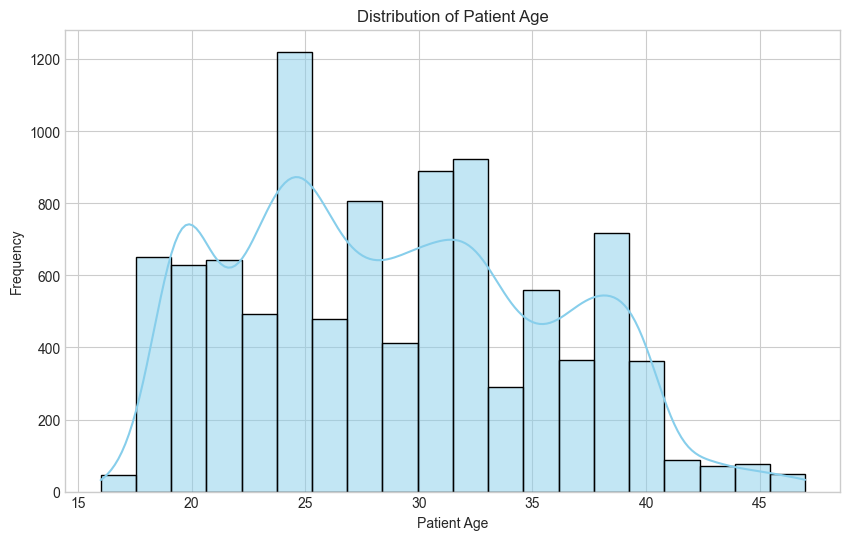

In [22]:

plt.style.use('seaborn-v0_8-whitegrid')

# Plot distribution of a numerical feature (e.g., PatientAge)
plt.figure(figsize=(10, 6))
sns.histplot(X['PatientAge'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\zainm\AppData\Local\Temp\ipykernel_23176\3797530722.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette='viridis', order=y.value_counts().index)


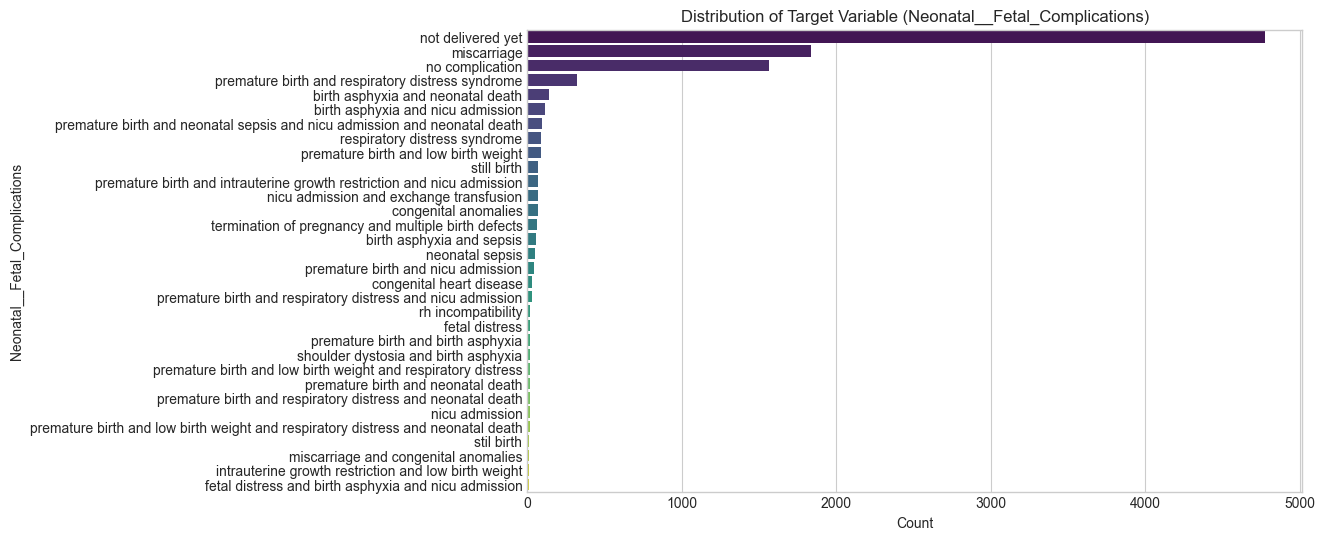

In [23]:
# Plot count of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(y=y, palette='viridis', order=y.value_counts().index)
plt.title('Distribution of Target Variable (Neonatal__Fetal_Complications)')
plt.xlabel('Count')
plt.ylabel('Neonatal__Fetal_Complications')
plt.show()

In [24]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nData split into training and testing sets.")


Data split into training and testing sets.


In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}



Starting model training and evaluation...

Training Logistic Regression...
Logistic Regression Accuracy: 0.9015
Classification Report for Logistic Regression:
                                                                                  precision    recall  f1-score   support

                                               birth asphyxia and neonatal death       0.41      0.33      0.37        42
                                               birth asphyxia and nicu admission       0.55      0.47      0.51        34
                                                       birth asphyxia and sepsis       1.00      0.88      0.93        16
                                                            congenital anomalies       0.62      0.40      0.48        20
                                                        congenital heart disease       0.00      0.00      0.00         9
                                                                  fetal distress       1.00      0.83      

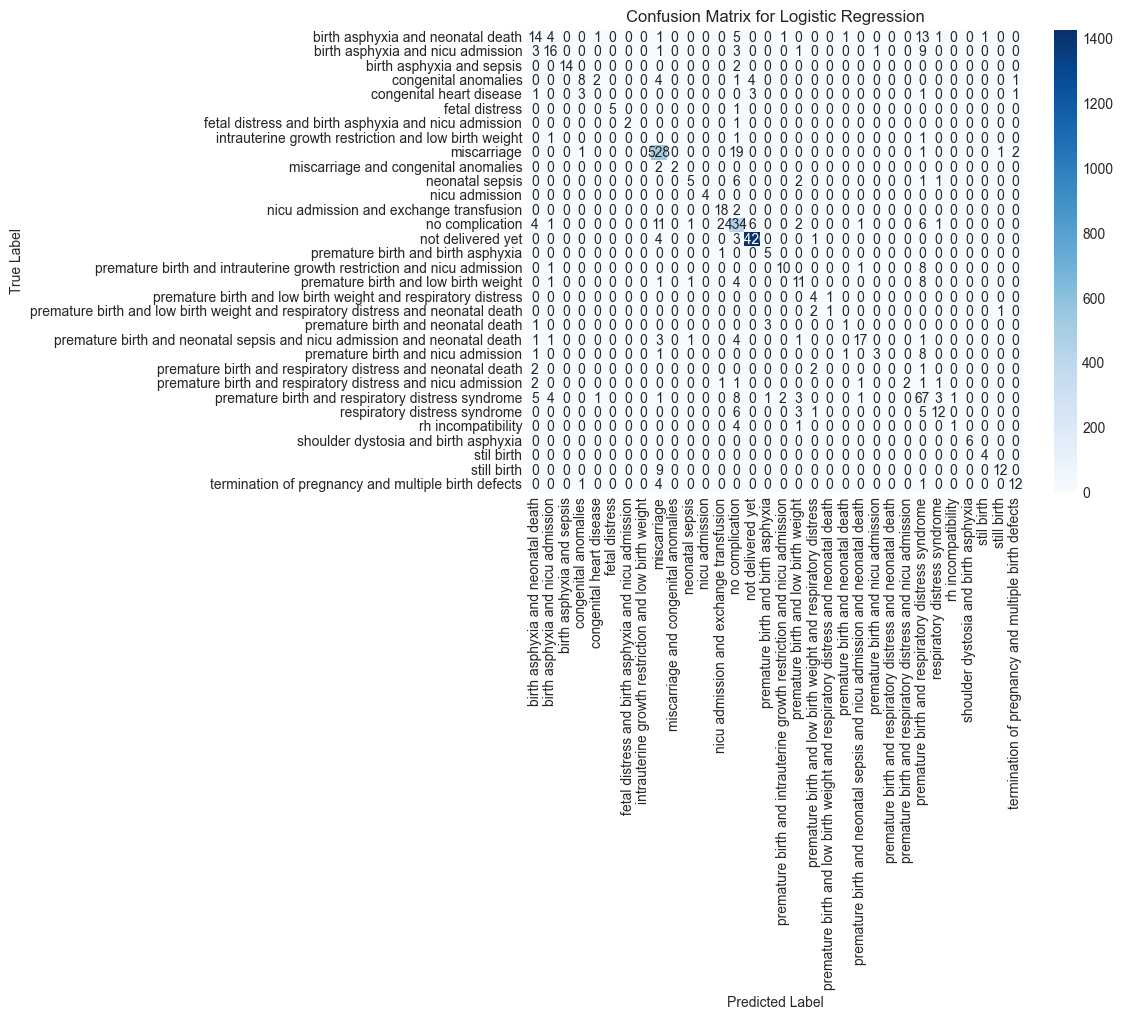


Training Random Forest...
Random Forest Accuracy: 0.8861
Classification Report for Random Forest:
                                                                                  precision    recall  f1-score   support

                                               birth asphyxia and neonatal death       0.71      0.12      0.20        42
                                               birth asphyxia and nicu admission       1.00      0.38      0.55        34
                                                       birth asphyxia and sepsis       1.00      0.81      0.90        16
                                                            congenital anomalies       0.00      0.00      0.00        20
                                                        congenital heart disease       0.00      0.00      0.00         9
                                                                  fetal distress       1.00      0.50      0.67         6
                            fetal distress and

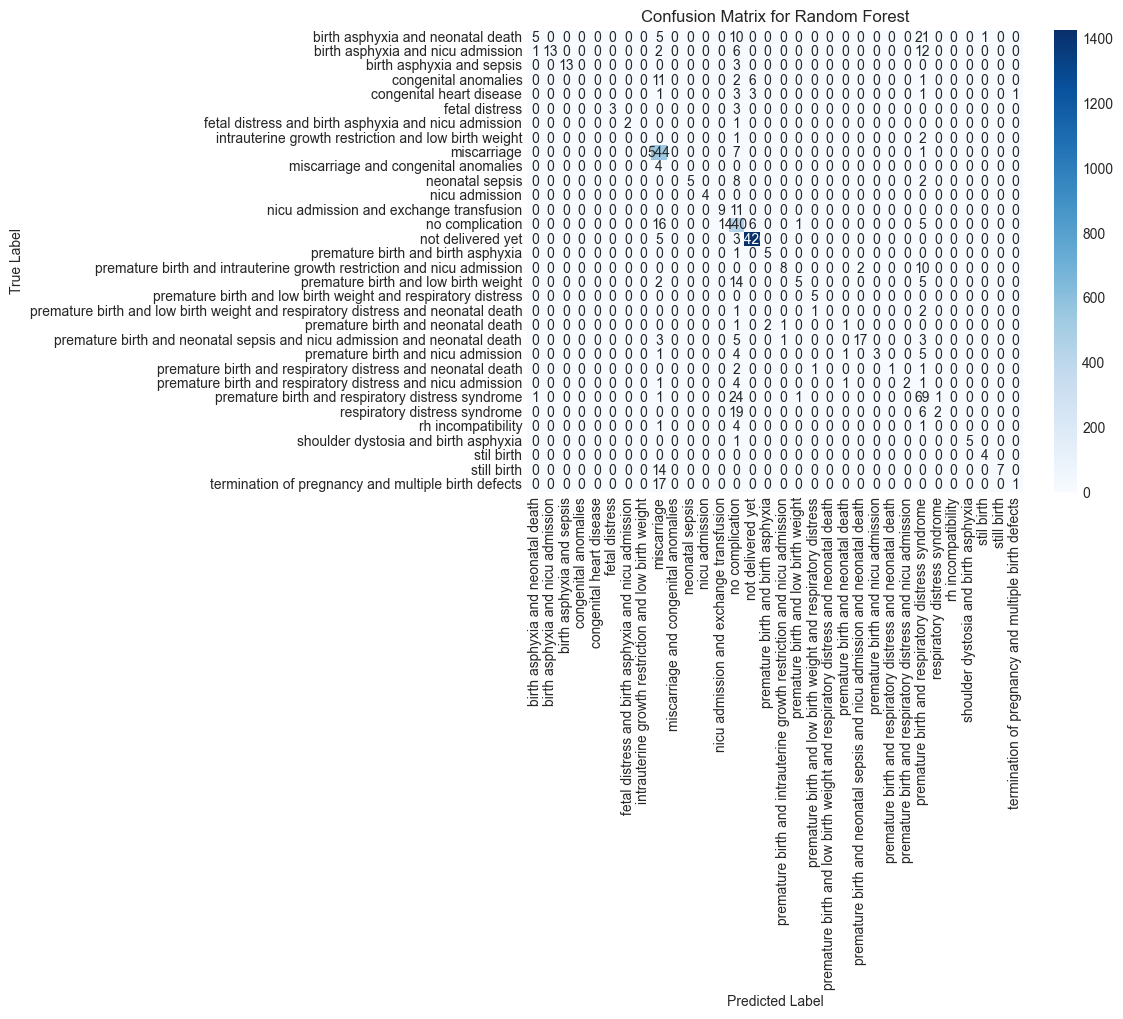


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8875
Classification Report for Gradient Boosting:
                                                                                  precision    recall  f1-score   support

                                               birth asphyxia and neonatal death       0.32      0.31      0.31        42
                                               birth asphyxia and nicu admission       0.54      0.38      0.45        34
                                                       birth asphyxia and sepsis       1.00      0.94      0.97        16
                                                            congenital anomalies       0.63      0.60      0.62        20
                                                        congenital heart disease       0.40      0.22      0.29         9
                                                                  fetal distress       0.86      1.00      0.92         6
                            fetal 

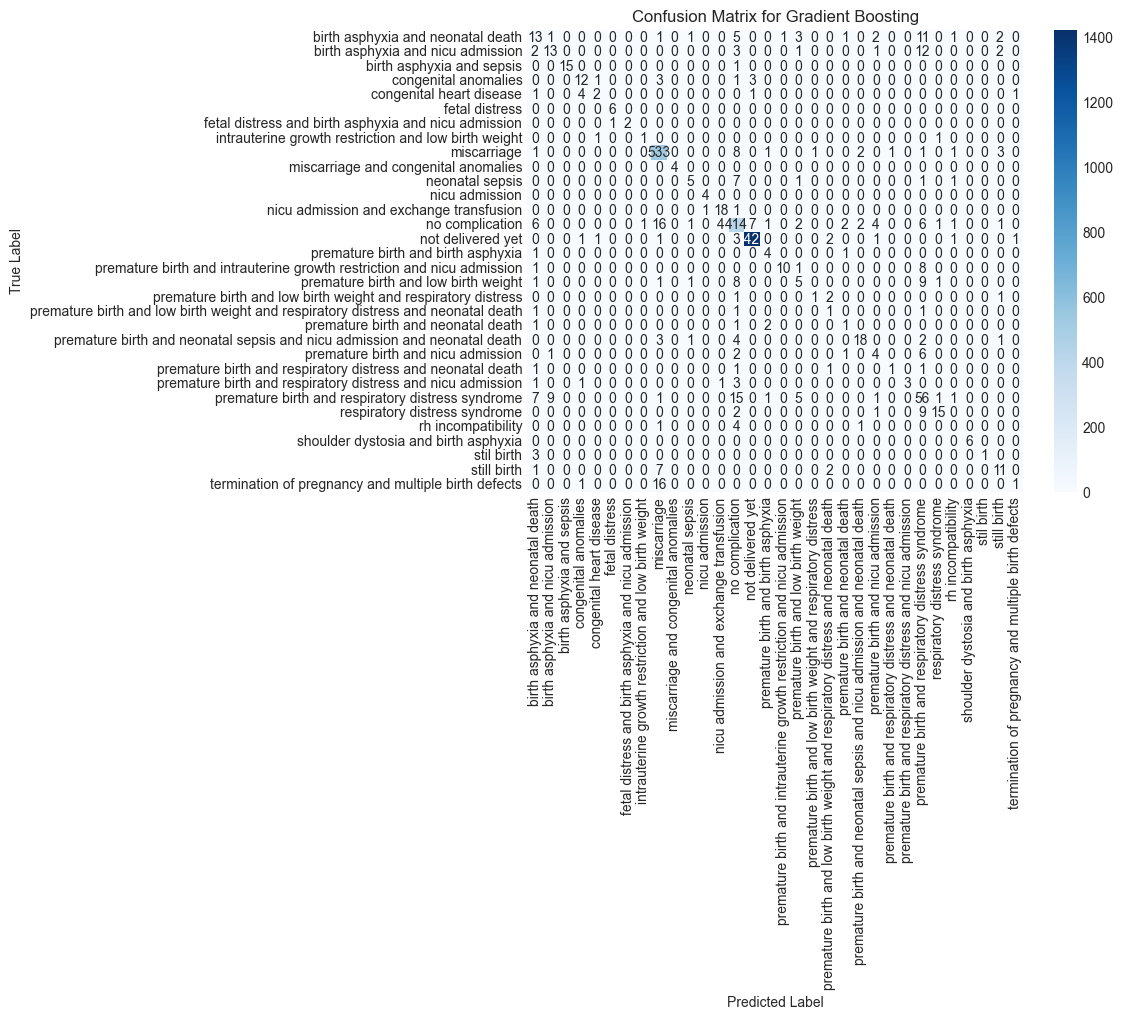

In [27]:

results = {}
pipelines = {} # Dictionary to store trained pipelines

print("\nStarting model training and evaluation...")
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create a full pipeline with the preprocessor and the model
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])

    # Train the model
    full_pipeline.fit(X_train, y_train)

    # Store the trained pipeline
    pipelines[name] = full_pipeline

    # Make predictions
    y_pred = full_pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:\n{report}")

    # Optional: Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

C:\Users\zainm\AppData\Local\Temp\ipykernel_23176\3829775270.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='deep')


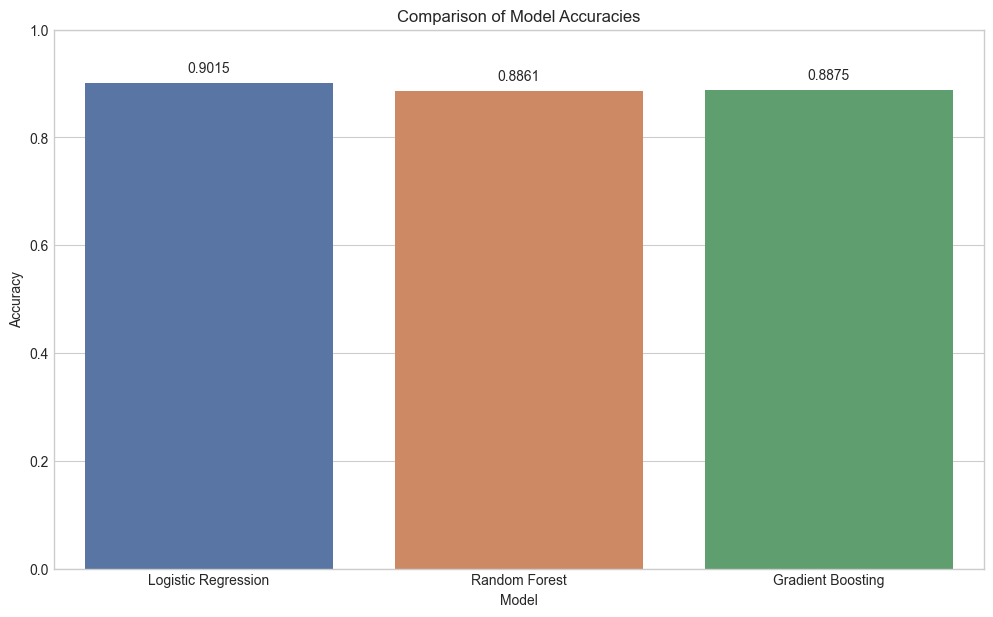

In [28]:
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(12, 7))
sns.barplot(x=model_names, y=accuracies, palette='deep')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()

In [29]:
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
best_pipeline = pipelines[best_model_name]

print(f"\n--- Final Result ---")
print(f"The best performing model is: {best_model_name}")
print(f"With an accuracy of: {best_model_accuracy:.4f}")


--- Final Result ---
The best performing model is: Logistic Regression
With an accuracy of: 0.9015


In [30]:
model_filename = 'best_neonatal_complications_prediction_model.joblib'
try:
    joblib.dump(best_pipeline, model_filename)
    print(f"\nBest model saved to {model_filename}")
except Exception as e:
    print(f"\nError saving the model: {e}")


Best model saved to best_neonatal_complications_prediction_model.joblib
